### Import libraries

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

import warnings
warnings.filterwarnings('ignore')

In [2]:
#import nltk
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')

## Loading the data

In [3]:
train = pd.read_excel('data/train.xlsx')
test = pd.read_excel('data/test.xlsx')
train.shape, test.shape

((676, 7), (295, 7))

In [4]:
train.head()

,Id,Category,Topic,Source,Headline,Text,Link
0,1,Fake,Education,El Ruinaversal,"RAE INCLUIRÁ LA PALABRA ""LADY"" EN EL DICCIONAR...","RAE INCLUIRÁ LA PALABRA ""LADY"" EN EL DICCIONAR...",http://www.elruinaversal.com/2017/06/10/rae-in...
1,2,Fake,Education,Hay noticia,"La palabra ""haiga"", aceptada por la RAE","La palabra ""haiga"", aceptada por la RAE La Rea...",https://haynoticia.es/la-palabra-haiga-aceptad...
2,3,Fake,Education,El Ruinaversal,YORDI ROSADO ESCRIBIRÁ Y DISEÑARÁ LOS NUEVOS L...,YORDI ROSADO ESCRIBIRÁ Y DISEÑARÁ LOS NUEVOS L...,http://www.elruinaversal.com/2018/05/06/yordi-...
3,4,True,Education,EL UNIVERSAL,UNAM capacitará a maestros para aprobar prueba...,UNAM capacitará a maestros para aprobar prueba...,http://www.eluniversal.com.mx/articulo/nacion/...
4,5,Fake,Education,Lamula,pretenden aprobar libros escolares con conteni...,Alerta: pretenden aprobar libros escolares con...,https://redaccion.lamula.pe/2018/06/19/memoria...


## Exploring the data

Let's start to see an overview of more repeated words using wordcloud

In [5]:
fake_news = train[train['Category'] == 'Fake']
real_news = train[train['Category'] == 'True']

In [6]:
def plot_wordcloud(text):
    wordcloud = WordCloud(width=800, height=800,
                          background_color='white',
                          min_font_size=10,
                          stopwords=stopwords.words('spanish')).generate(fake_words)
    plt.figure(figsize=(8,8), facecolor=None)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off');

In [7]:
fake_words = ""
real_words = ""

for text in fake_news['Text']:
    text.lower()
    fake_words += " "+text.lower()
    
for text in real_news['Text']:
    text.lower()
    real_words += " "+text.lower() 

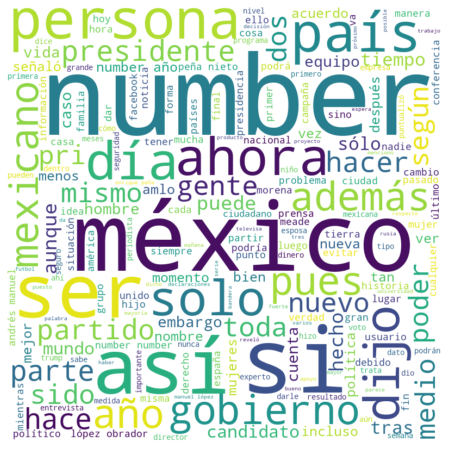

In [8]:
plot_wordcloud(fake_words)

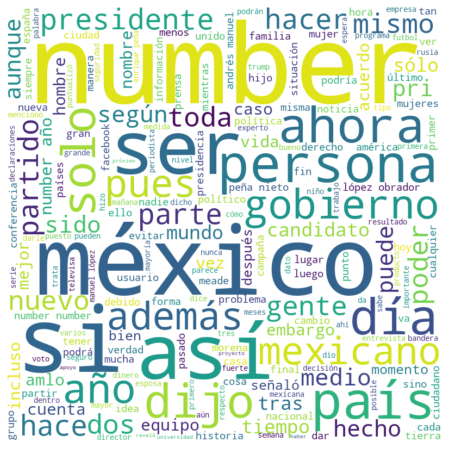

In [9]:
plot_wordcloud(real_words)

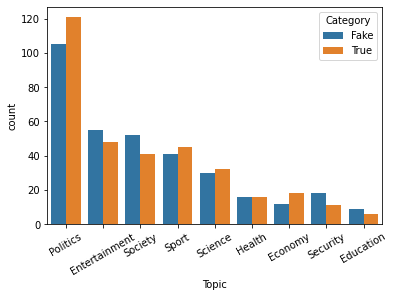

In [10]:
sns.countplot(x='Topic', hue='Category', data=train, 
              order = train['Topic'].value_counts().index);
plt.xticks(rotation=30);

## Preprocessing text news

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 676 entries, 0 to 675
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        676 non-null    int64 
 1   Category  676 non-null    object
 2   Topic     676 non-null    object
 3   Source    676 non-null    object
 4   Headline  676 non-null    object
 5   Text      676 non-null    object
 6   Link      676 non-null    object
dtypes: int64(1), object(6)
memory usage: 37.1+ KB


* No missing values

In [12]:
def remove_punctuation(string):
    return re.sub(r'[^\w\s]','', string)

In [13]:
remove_punctuation('--.,hello./>')

'hello'

In [14]:
nltk.word_tokenize('Hello how are you')

['Hello', 'how', 'are', 'you']

In [49]:
import spacy

# python -m spacy download es_core_news_sm

nlp = spacy.load('es_core_news_sm')

def lemmatizer(text):  
    doc = nlp(text)
    return ' '.join([word.lemma_ for word in doc])

def preprocess_text(df)
    for index, row in df.iterrows():
        text = row['Text']
        # Remove punctuation
        text = remove_punctuation(text.lower())
        # Tokenize
        word_list = nltk.word_tokenize(text)
        # Remove stopwords
        word_list = [word for word in word_list if not word in stopwords.words('spanish')]
        # Lemmatizer
        processed_text = lemmatizer(" ".join(word_list))
        df.loc[index, 'Processed_Text'] = processed_text

In [ ]:
%%time
preprocess_text(train)

In [50]:
train[['Text', 'Processed_Text']].head()

,Text,Processed_Text
0,"RAE INCLUIRÁ LA PALABRA ""LADY"" EN EL DICCIONAR...",raer incluir palabra lady diccionario idioma e...
1,"La palabra ""haiga"", aceptada por la RAE La Rea...",palabra haiga aceptar raer real academia lengu...
2,YORDI ROSADO ESCRIBIRÁ Y DISEÑARÁ LOS NUEVOS L...,yordi rosado escribir diseñar nuevo libro text...
3,UNAM capacitará a maestros para aprobar prueba...,unam capacitar maestro aprobar probar pisar má...
4,Alerta: pretenden aprobar libros escolares con...,alertar pretender aprobar libro escolar conten...


## Modeling

In [70]:
X_train = train['Processed_Text'].copy()
y_train = train['Category'].copy()
y_train = y_train.apply(lambda cat: 1 if cat == 'Fake' else 0)

In [71]:
count_vectorizer = CountVectorizer()
freq_term_matrix = count_vectorizer.fit_transform(X_train)
tfidf = TfidfTransformer(norm='l2')
tfidf_matrix = tfidf.fit_transform(freq_term_matrix)

In [72]:
tfidf_matrix.shape

(676, 14915)

In [73]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(tfidf_matrix, y_train)

In [74]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((507, 14915), (507,), (169, 14915), (169,))

In [75]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression()

In [78]:
y_pred = log_reg.predict(X_val)
print(log_reg.score(X_train, y_train))
print(log_reg.score(X_val, y_val))

0.980276134122288
0.7692307692307693


In [80]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, y_pred)
cm

array([[62, 19],
       [20, 68]])